# Using Neural Networks To Solve The Problem

The below code has been adapted from [this article](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/) on text generation with LSTM and [this article](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17) on classification with LSTM.

In [51]:
#Let's suppress the matplotlib deprecation warning here
import warnings
warnings.filterwarnings("ignore")

# Gotta bring some mates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.callbacks import EarlyStopping

import re
from spacy.lang.en.stop_words import STOP_WORDS
import spacy

from sklearn.model_selection import train_test_split

In [16]:
nlp = spacy.load("en_core_web_lg")

In [4]:
df = pd.read_csv('../data/bechdel_df.csv')
df.head()

,Unnamed: 0,rating,title,year,imdbid,script,simple_bechdel
0,0,1,warrior,2011,1291584.0,WARRIOR ...,0
1,1,1,collateral,2004,369339.0,COLLA...,0
2,8,1,gamer,2009,1034032.0,GAMER ...,0
3,9,1,wanted,2008,493464.0,WANTED ...,0
4,10,0,2001: a space odyssey,1968,62622.0,2001: A SPACE ODYSSEY Screenplay by ...,0


In [5]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [6]:
df.head()

,rating,title,year,imdbid,script,simple_bechdel
0,1,warrior,2011,1291584.0,WARRIOR ...,0
1,1,collateral,2004,369339.0,COLLA...,0
2,1,gamer,2009,1034032.0,GAMER ...,0
3,1,wanted,2008,493464.0,WANTED ...,0
4,0,2001: a space odyssey,1968,62622.0,2001: A SPACE ODYSSEY Screenplay by ...,0


In [18]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['script'] = df['script'].apply(clean_text)
df['script'] = df['script'].str.replace('\d+', '')


<ipython-input-18-f19cb3781898>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['script'] = df['script'].str.replace('\d+', '')


### A quick check on the output

In [20]:
df['script'][42]

'midnight epress screenplay oliver stone based autobiography billy hayes william hoffer revised draft june  prologue black screen superimpose following based true story october   istanbul turkey sound sharp crackle rip snip fade set clothes hotel room bed trenchcoat bulky white turtleneck sweater tshirt jeans western style boots sounds continue accentuated open travel bags bed clothes possessions continue furniture washbasin toileta large room high old ceilings windows suggesting ancient europe design haunting greenish afternoon light hands tight drawing strip adhesive tape scissors tightsnip underarm tight tape laid shoulder tight tape going bellybutton tight tape going harsh rip sound tape comes bellybutton hands new strip tape moving hashish plaque thinly pressed hand wrapping portion tape belly tight sounds breathing stop belly sucked tape pulled hard clinched hear f heart beat chest billy hayes  babyface attractive medium build aura innocence eyes moving belly mirror shot clima cr

In [23]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['script'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 253114 unique tokens.


In [27]:
X = tokenizer.texts_to_sequences(df['script'].values)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (459, 26426)


In [28]:
Y = df['simple_bechdel'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (459,)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(f'X_train is: {X_train.shape} and Y_train is: {Y_train.shape}')
print(f'X_test is: {X_test.shape} and Y_test is: {Y_test.shape}')

X_train is: (344, 26426) and Y_train is: (344,)
X_test is: (115, 26426) and Y_test is: (115,)


### Fitting and running the LSTM Model

I started out following the exact instructions of the article from Susan Li before tinkering with the model to work on the overall results, with a simple tweak for it to be for binary classification instead of multi-class.

I set the first part of the Embedding layer to the total number of tokens found in the dataframe (+1). If this takes too long I will go back and choose a maximum number for this as this might be too computationally expensive otherwise.

In [54]:
model = Sequential()
model.add(Embedding(253115, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2)) #for variational dropout
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 6
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.25,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/6
5/5 [==============================] - 541s 106s/step - loss: 2.7300 - accuracy: 0.4972 - val_loss: 1.0285 - val_accuracy: 0.5698
Epoch 2/6
5/5 [==============================] - 523s 104s/step - loss: 1.0285 - accuracy: 0.5098 - val_loss: 0.7035 - val_accuracy: 0.5698
Epoch 3/6
5/5 [==============================] - 530s 105s/step - loss: 1.5541 - accuracy: 0.6026 - val_loss: 0.6914 - val_accuracy: 0.5349
Epoch 4/6
5/5 [==============================] - 536s 107s/step - loss: 0.5836 - accuracy: 0.6356 - val_loss: 0.7392 - val_accuracy: 0.5698
Epoch 5/6
5/5 [==============================] - 550s 110s/step - loss: 0.6283 - accuracy: 0.4881 - val_loss: 0.7584 - val_accuracy: 0.5698
Epoch 6/6
5/5 [==============================] - 538s 107s/step - loss: 0.6024 - accuracy: 0.5039 - val_loss: 0.7552 - val_accuracy: 0.5698


### Saving Models

I will be saving each model, rather than pickling them, as recommended by Jason Brownlee in [this article](https://machinelearningmastery.com/save-load-keras-deep-learning-models/).

In [52]:
model.save('../assets/model_1.h5')
print('Saved model to assets folder. Please remember to change number above before saving next model.')

Saved model to assets folder. Please remember to change number above before saving next model.


### Plotting the Models

Below we can see how our models perform across the epochs.

Information from each iteration:

1. loss: 0.4668 - accuracy: 0.9179 - val_loss: 0.6894 - val_accuracy: 0.6000

The first model that was run was incredibly overfit. We are going to need to work on this some more.

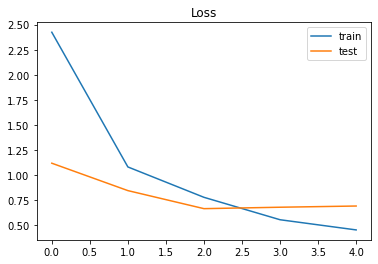

In [48]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

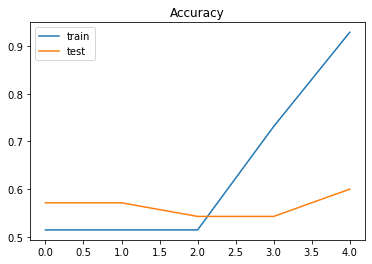

In [50]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();